# Step 1: Loading empirical calibration data

For the first tutorial, the goal is to better understand empirical calibration of a pressure measuring probe.
Empirical calibration is the current convention to calibrate microphone probes.
Looking at the empirical method, spurious 'calibrator-induced' resonance in the calibration of the probe will appear. Understanding the empirical method, shows where the spurious resonance comes from, and it forms a part of the semi-empirical calibration method presented to resolve this spurious resonance.

In [40]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
SAVE_READING = False
import os
import numpy as np
from Source.PlottingFunctions import plot_transfer_function_df
from Source.CalibrationMeasurement import PressureAcquisition

Firstly, the empirical (frequency-domain) calibration data needs to be loaded. The os.path.join function creates the file-path from the various strings, with the correct path separator (/, \\) for the specific operating system.

In [41]:
FILE_PATH_FLUSH_CALIBRATION_STEP = os.path.join('..', 'TestData', 'BK_Pinhole', 'Flush_1.tdms')

A Python class *PressureAcquisition* is provided to load the file, at the provided file-path, into a pandas DataFrame. The methods (functions of a class) can then be used to further process the calibration (or unsteady pressure measurement) data. When calling the class with the desired settings, an object is created, which is simply that specific instance of the class.

The main input it the file-path *file_path* and the sampling frequency *fs* of the data. A safer, but slower, data reading method can be used by setting *safe_read* to True. Other input parameters are available for the class, but aren't discussed for now.

In [42]:
obj_cal_flush_step = PressureAcquisition(file_path=FILE_PATH_FLUSH_CALIBRATION_STEP, fs=51200, safe_read=SAVE_READING)

Reading the TDMS file into a DataFrame, one can see the structure of the data. Each (readable) channel of data in the TDMS file is read into a column of the DataFrame, with their own column name. The column names have two levels (Group and Channel), e.g., ('Untitled', 'Channel 1'). The left-most column is the index, i.e., row name, of the channels, in this case it is simply the row or sample number. The data within the DataFrame is whatever is provided by the LabVIEW VI, in this case voltage.

In [43]:
print(obj_cal_flush_step.df_data)

Group    Untitled                    
Channel Channel 1 Channel 2 Channel 3
0       -0.081024 -0.402222  0.321503
1       -0.192108 -0.321198 -0.030823
2       -0.236816 -0.146484 -0.078125
3       -0.175781  0.056915  1.073303
4       -0.139008  0.203552 -1.564789
...           ...       ...       ...
3071995 -0.104523 -0.002747 -0.363312
3071996 -0.014191  0.037231 -0.216217
3071997  0.110168  0.052948 -0.194550
3071998  0.128632  0.027313  0.530090
3071999  0.056763 -0.012665 -0.256500

[3072000 rows x 3 columns]


Several processing methods are provided in the *PressureAcquisition* class. The first such method is *raw*, which simply returns a copy of the desired columns of *obj_cal_flush_step.df_data*, see the first line of the code below per example. Here the specific desired data columns are specified with *which*, e.g., *which=[(Untitled, Channel 1), (Untitled, Channel 3)]*, or return all channels with *which='all'*.

The results of all processing methods can be visualised with the input parameter *visualise=True*. Once the visualisation is turned-on, further plotting parameters can be provided. These parameters are that of *Source.PlottingFunctions.plot_single_df* for all but the transfer functions, which uses *Source.PlottingFunctions.plot_transfer_function_df*. If *visualise=True*, the method will return a tuple instead of a DataFrame with the processing results. The first element of the tuple will be the aforementioned DataFrame, the second element is a tuple of the Matplotlib plotting object (fig, ax).

Below one can see the time-series data in the TDMS files. This can show if there is any clipping of the data or possibly other problems.

C:\Users\olivi\Documents\TU_Delft\5th_Msc\Thesis\SemiEmpiricalCalibrationBayesian\Source\PlottingFunctions.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_t.show()


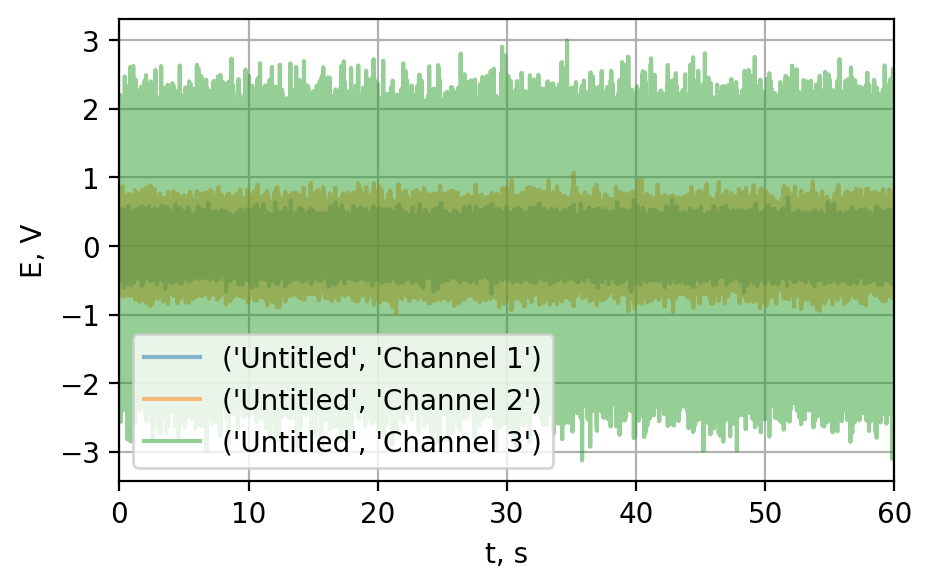

In [44]:
df_cal_flush_raw_all = obj_cal_flush_step.raw(which='all')
del df_cal_flush_raw_all
df_cal_flush_raw_all, (fig_raw, ax_raw) = obj_cal_flush_step.raw(
    which='all', visualise=True, fig_dim=(5, 3), x_lim=(0, 60), legend_loc='lower left', alpha=0.5)

The second and third processing methods are *obj_cal_flush_step.psd* and *obj_cal_flush_step.psd_norm*, which return (and visualise) the power spectral density (PSD) and a normalised PSD $10 \log_{10} (PSD / p_{ref}^2)$ with $p_{ref}=2E-5$Pa.
Naturally, this normalised PSD doesn't make sense in all cases.

In the PSD, the energy of the signal in the frequency-domain can be analysed. Again, this can help debug any possible issues. The PSD of the speaker voltage can show the type of signal used for the calibration, in this case white-noise.

C:\Users\olivi\Documents\TU_Delft\5th_Msc\Thesis\SemiEmpiricalCalibrationBayesian\Source\PlottingFunctions.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_t.show()


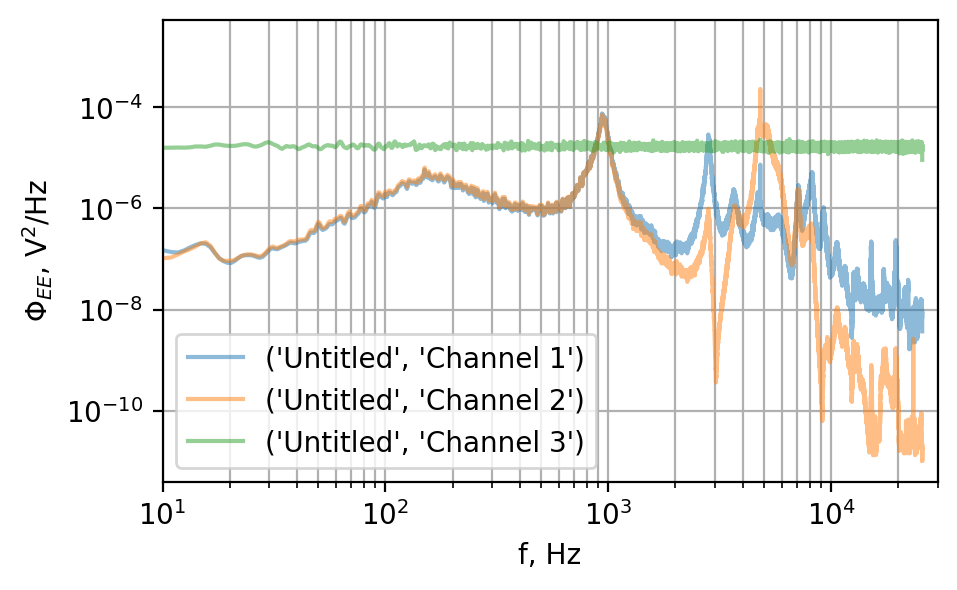

In [45]:
df_psd, (fig_psd, ax_psd) = obj_cal_flush_step.psd(
    which='all', visualise=True, fig_dim=(5, 3), alpha=0.5, legend_loc='lower left',
    y_str=r"$\Phi_{EE}$, V$^2$/Hz", x_scale='log', y_scale='log', x_lim=(1E1, 3E4))

The remaining two processing methods analyse the relation between two of the acquired signals, therefore the input and output signals are defined.
For the specific methods, these variables should be lists of tuples. Each tuple is a data channel (group, channel). The input and output list should have the same length.

In [46]:
INPUT_CHANNEL_FLUSH_CALIBRATION = [('Untitled', 'Channel 1')]
OUTPUT_CHANNEL_FLUSH_CALIBRATION = [('Untitled', 'Channel 2')]

The fourth processing method is the cross-coherence, i.e., how strongly the signals are related to each other. If the output signal is strongly linked to the input signal, and not as much by strong external noise sources, the cross-coherence is high, and vise versa. This metric ranges from zero to one.

If the calibration signal doesn't properly cover a certain frequency range (see the speaker signal PSD), then the coherence within that frequency range might be low. When resonance is present at a given frequency, the coherence might also drop.

C:\Users\olivi\Documents\TU_Delft\5th_Msc\Thesis\SemiEmpiricalCalibrationBayesian\Source\PlottingFunctions.py:188: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_t.show()


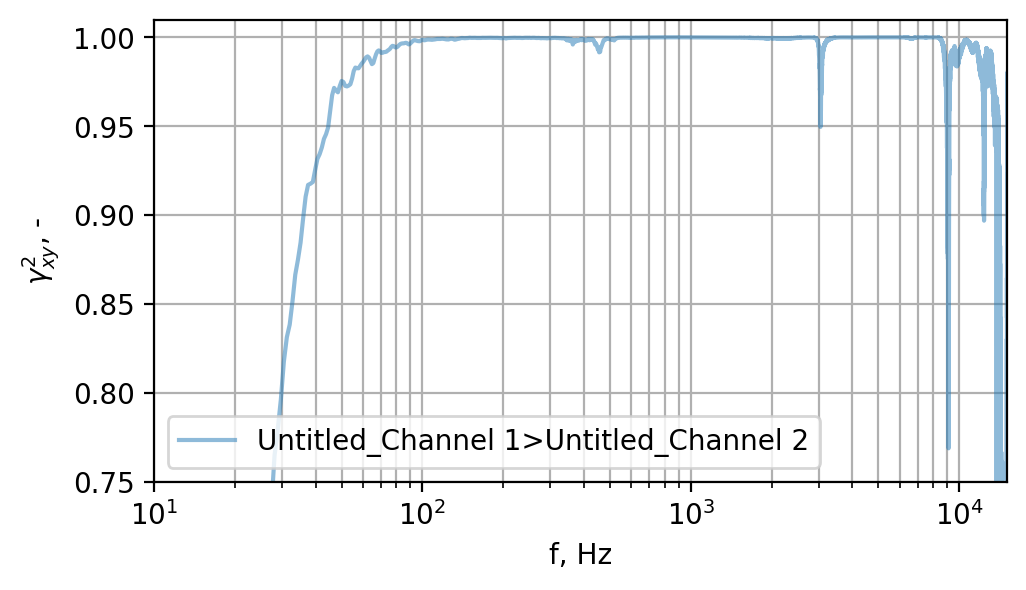

In [47]:
df_coh, (fig_coh, ax_coh) = obj_cal_flush_step.cross_coherence(
    in_channel=INPUT_CHANNEL_FLUSH_CALIBRATION, out_channel=OUTPUT_CHANNEL_FLUSH_CALIBRATION, visualise=True, fig_dim=(5.5, 3),
    alpha=0.5, legend_loc='lower left', y_str=r"$\gamma^2_{xy}$, -", x_scale='log', x_lim=(1E1, 1.5E4), y_lim=(0.75, 1.01))

The fifth, and final, processing method is the transfer function (TF). This summarises the frequency-dependent amplification/attenuation and phase delay between the input and output signals. This is also used to correct unsteady pressure measurements for the impact of the remote microphone probe (RMP) tubes and cavities on the acquired probe signal. The TF indicates viscous attenuation and resonance, linked to either cavity or tube.

Resonance can be seen in both the amplitude and phase of the TF. For the amplitude, resonance results in a large amplification peak or attenuation dip, depending on the direction of the TF. For the phase, resonance causes a shift in phase delay of +$\pi$ rad or -$\pi$ rad, depending on the direction of the TF. As resonance occurs at the resonant frequencies, both amplitude and phase effect happen at the same frequency.

C:\Users\olivi\Documents\TU_Delft\5th_Msc\Thesis\SemiEmpiricalCalibrationBayesian\Source\PlottingFunctions.py:284: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_t.show()


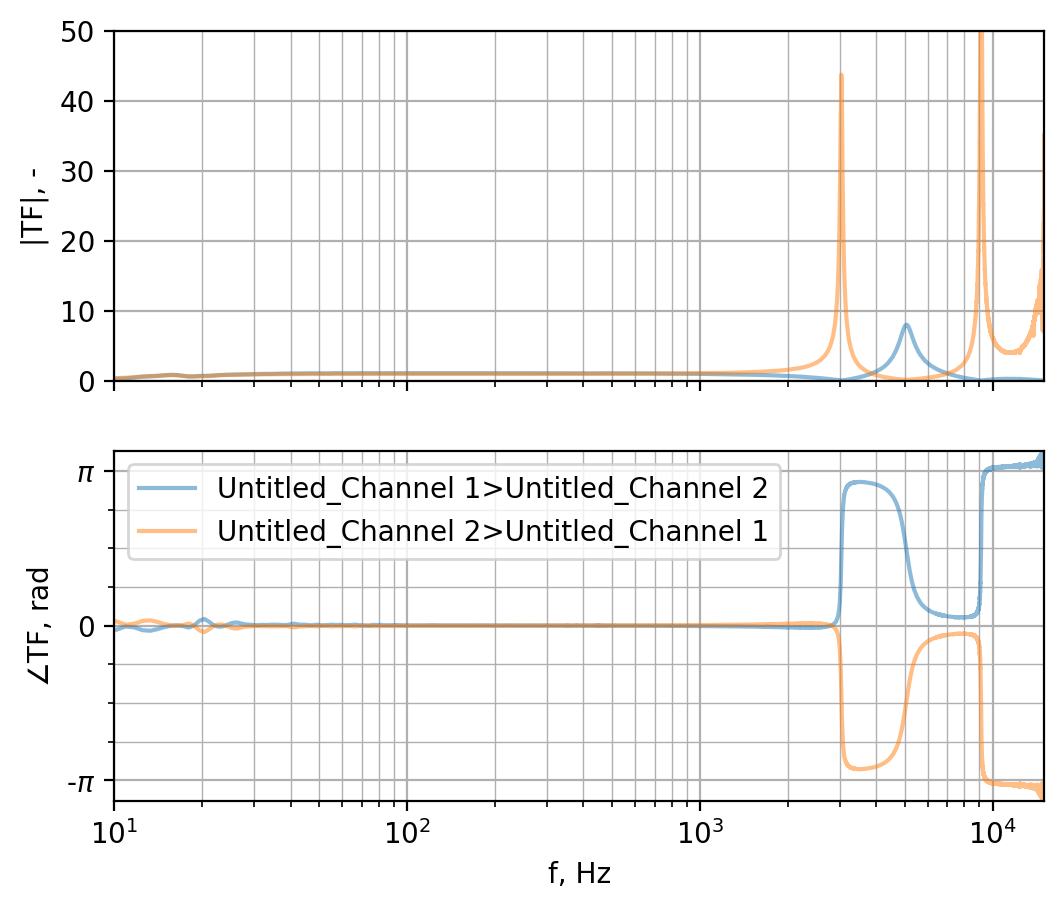

In [48]:
obj_cal_flush_step.transfer_function(
    in_channel=INPUT_CHANNEL_FLUSH_CALIBRATION+OUTPUT_CHANNEL_FLUSH_CALIBRATION,
    out_channel=OUTPUT_CHANNEL_FLUSH_CALIBRATION+INPUT_CHANNEL_FLUSH_CALIBRATION,
    visualise=True, alpha=0.5, legend_loc='upper left', x_lim=(1E1, 1.5E4), minor_phase=0.25, y_lim_amp=(0, 50),
    y_lim_phase=(-1.1*np.pi-0.1, 1.1*np.pi+0.1), linestyle='-', color=None, fig_dim=(6, 5));

In the above figure, one can see three resonances at: 3 kHz, 5 kHz, and 9 kHZ. Going from Channel 1 to Channel 2 (flush-mounted microphone to calibrator side-branch microphone), the resonance at 3 and 9 kHz are inverse (the inverse of the resonant amplification peak), the resonance at 5 kHz is cavity resonance. Through understanding the geometry of the probe, the source of the resonances can be understood: $$ f_{r, \ half-closed \ line} = \frac{n \pi}{4 L} \quad \text{with} \ \ n = {1, 3, ...} $$ $$ f_{r, \ cavity} = \frac{c}{2 \pi L} \sqrt{\frac{V_t}{V_v}} $$

Here the geometry of the probe can be divided into tubes with a possible volume at the end of the tube section. Discontinuities of tubes, e.g., in diameter, can be seen as multiple sections of tube with a continuous cross-section. Each section has their own line resonance. The tubes have a length $L$, a radius $R$, and therefore a tube volume $V_t = L \pi R^2$, with a cavity volume at the end $V_v$.

For the multi-step calibration approach, the TF of the flush-mounted calibration step is defined in the following way.

C:\Users\olivi\Documents\TU_Delft\5th_Msc\Thesis\SemiEmpiricalCalibrationBayesian\Source\PlottingFunctions.py:284: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_t.show()


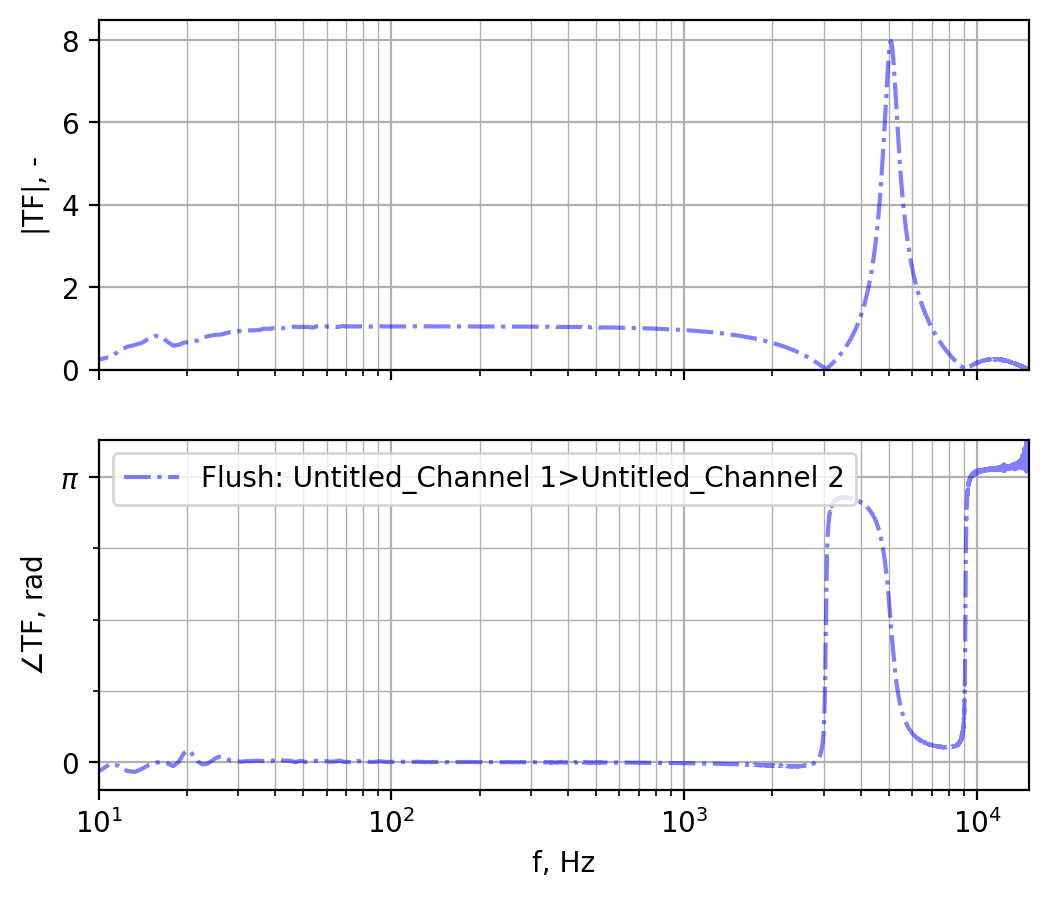

In [49]:
df_cal_flush_tf, _ = obj_cal_flush_step.transfer_function(
    in_channel=INPUT_CHANNEL_FLUSH_CALIBRATION, out_channel=OUTPUT_CHANNEL_FLUSH_CALIBRATION, visualise=True,
    legend_loc='upper left', alpha=0.5, x_lim=(1E1, 1.5E4), minor_phase=0.25, prefix='Flush: ', y_lim_amp=(0, 8.5),
    y_lim_phase=(-0.3, 1.1*np.pi+0.1), linestyle='-.', color='b', fig_dim=(6, 5))

The same TF can be found for the other calibration steps, in this case the second of two  calibration steps. The input and output channels for this calibration step are also defined.

In [50]:
FILE_PATH_MIC_CALIBRATION_STEP = os.path.join('..', 'TestData', 'BK_Pinhole', 'Pinhole_1.tdms')
INPUT_CHANNEL_MIC_CALIBRATION = [('Untitled', 'Channel 2')]
OUTPUT_CHANNEL_MIC_CALIBRATION = [('Untitled', 'Channel 1')]

In [51]:
obj_cal_mic_step = PressureAcquisition(file_path=FILE_PATH_MIC_CALIBRATION_STEP, safe_read=SAVE_READING, fs=51200)

df_cal_mic_tf = obj_cal_mic_step.transfer_function(in_channel=INPUT_CHANNEL_MIC_CALIBRATION, out_channel=OUTPUT_CHANNEL_MIC_CALIBRATION)

dct_linking_both_tf_column_names = dict(zip(df_cal_flush_tf.columns, df_cal_mic_tf.columns))

df_cal_both_tf = obj_cal_flush_step.add_transfer_function_step(df_tf_new=df_cal_mic_tf,
                                                               dct_old_tf_to_new_tf_channels=dct_linking_both_tf_column_names)

C:\Users\olivi\Documents\TU_Delft\5th_Msc\Thesis\SemiEmpiricalCalibrationBayesian\Source\PlottingFunctions.py:284: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_t.show()


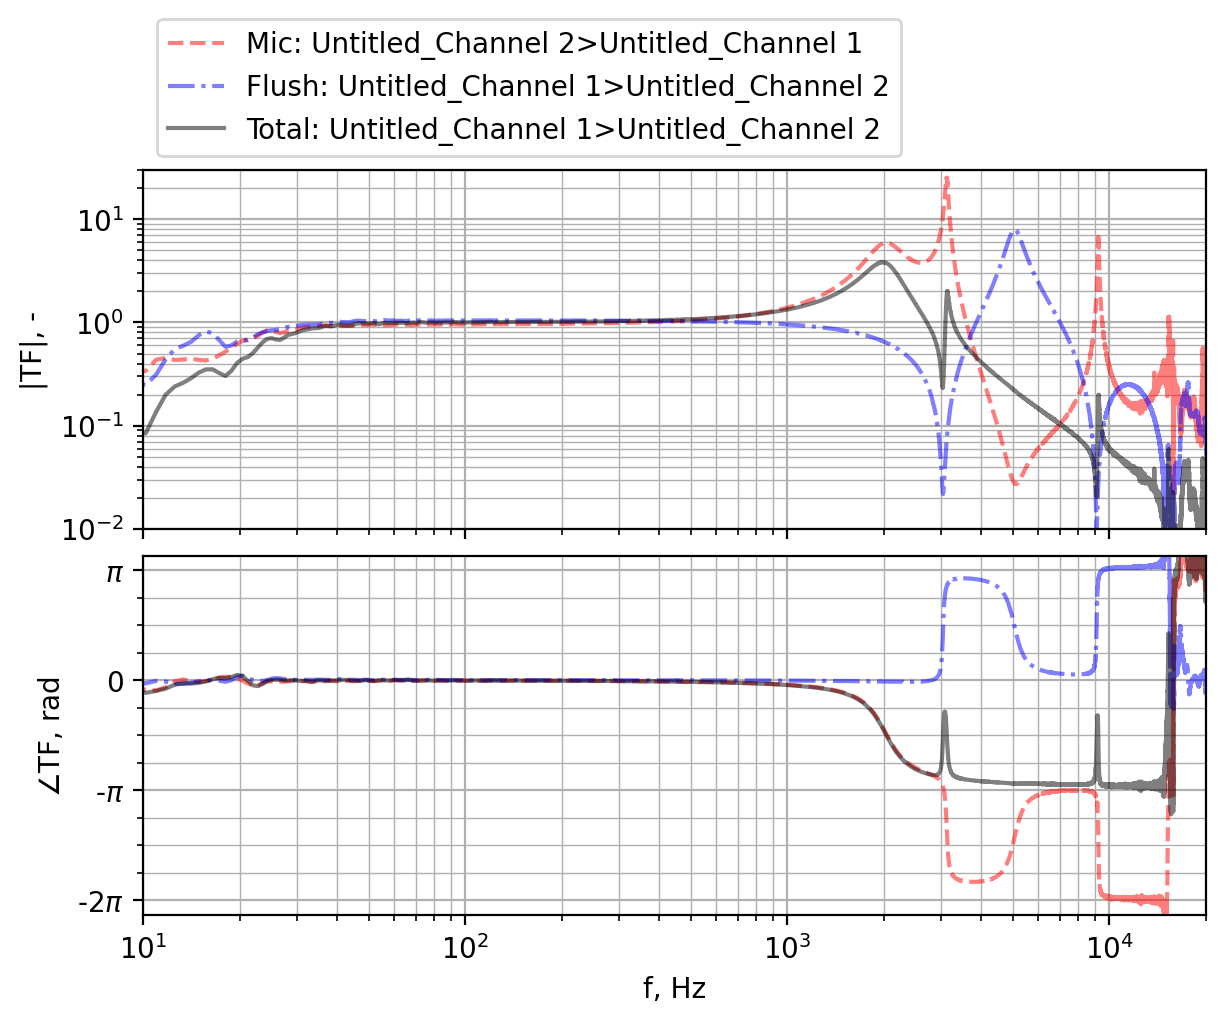

In [52]:
fig_tf_mic, ax_tf_mic = plot_transfer_function_df(df=df_cal_mic_tf, fig_dim=(6, 5), alpha=0.5, prefix='Mic: ', linestyle='--', color='r',
                                                  minor_phase=0.25, x_lim=(1E1, 2E4), y_lim_amp=(1E-2, 3E1), y_lim_phase=(-2.1*np.pi-0.1, 1.1*np.pi+0.1))
plot_transfer_function_df(df=df_cal_flush_tf, ax=ax_tf_mic, alpha=0.5, prefix='Flush: ', linestyle='-.', color='b');
plot_transfer_function_df(df=df_cal_both_tf, ax=ax_tf_mic, alpha=0.5, prefix='Total: ', linestyle='-', color='k');
ax_tf_mic[1].legend().remove();
ax_tf_mic[0].legend(loc='lower left', bbox_to_anchor=(0, 1));
ax_tf_mic[0].set_yscale('log');
fig_tf_mic.tight_layout(pad=0.2)

The above TF plot shows clearly how the TFs of both calibration steps combine to form the final TF of the probe. During this combination, the resonance linked to the calibrator itself ought to cancel as it affects both calibration steps equally. The resonance that is actually part of the probe only appears in the second calibration step and should therefore be all that is left, once both TFs are combined.

The final TF is what one expects from a simple pinhole style RMP; a single resonant frequency caused by the pinhole cavity. If the pinhole in the wall were longer, i.e., larger $L$, then line resonance would also show up. However, in most cases, the length of the pinhole in the wall is so short that the resonant frequencies (both fundamental and modes), lie in much higher frequencies than one aims to measure unsteady pressures at, and therefore above the frequency range that one calibrates.

It is also obvious that the TF stops being useful above ca. 15 kHz, where a lot of noise in the TF sets in. If the PSD of the speaker signal were to end at this frequency, it would indicate that that frequency range is simply not calibrated. In this case, the cut-off frequency of the plane-wave tube calibrator lies around 13.5 kHz. Above this frequency, the pressure waves within the calibrator can no longer be assumed plane, many transversal resonant modes start to show up, and the calibrator no longer provides a good calibration.

Lastly, in the final TF the resonant frequencies of the calibrator cancel, but not perfectly so. At 3 and 9 kHz, some thin peaks remain in both amplitude and phase, clearly linked to both calibration steps not combining perfectly. This is therefore not resonance that is associated with the RMP, but with the calibrator. Therefore, this *error* in the calibration of the RMP is termed **spurious resonance**. The method that is presented in this package aims to remove those spurious resonances by fitting analytical models for the TF of the probe to the empirically obtained TF data.